1. Разложение данных в разные таблички df
2. Обучение разных моделек на своих цветах
3. Соединение результатов

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install opencv-python

In [3]:
import numpy as np
import scipy.linalg as sla
from PIL import Image
from scipy import misc
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import timeit
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd

#from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA

import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix

from matplotlib import cm

from tqdm.auto import tqdm

from google.colab import files

import zipfile # Библиотека для работы с zip архивами
import os  

In [4]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## Загрузка данных

In [5]:
zip = "/content/drive/MyDrive/dataset.zip"

In [6]:
# # Распаковываем архив
z = zipfile.ZipFile(zip, 'r')
z.extractall()

# Просмотр результата разархивации
print(os.listdir())

['.config', '3', '5', '6', '8', '2', 'drive', '4', '1', '7', 'sample_data']


## Сбор датасетов

In [7]:
#name_folder = {0:'1', 1:'2', 2:'3', 3:'4', 4:'5', 5:'6', 6:'7', 7:'8'}

In [8]:
# # df_0 = pd.DataFrame(columns=[i for i in range(50176)])
# # df_1 = pd.DataFrame(columns=[i for i in range(50176)])
# # df_2 = pd.DataFrame(columns=[i for i in range(50176)])

# df_0 = np.zeros((0, 2))
# #df_1 = np.zeros((0, 2))
# #df_2 = np.zeros((0, 2))


# for b in name_folder.keys():

#   #path = '/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС'+f'/{name_folder[b]}'
#   path = '/content'+f'/{name_folder[b]}'

#   photos = os.listdir(path)

#   img_sl = {}

#   for i, photo in enumerate(tqdm(photos)):

#     photo_pth = f'{path}/'+f'{photo}'     

#     img = 255 - cv2.imread(photo_pth, cv2.COLOR_BGR2RGB)

#     # for n in range(3):

#     #   data0 = np.reshape(img[:,:,n], 50176)
#     #   data0 = pd.Series(data0)
#     #   img_sl[n] = data0

#     data0 = np.reshape(img[:,:,0], 50176)
#     data0 = pd.Series(data0)


#     df_0 = np.append(df_0, [[data0,b]], axis = 0)
#     #df_1 = np.append(df_1, [[img_sl[1],b]], axis = 0)
#     #df_2 = np.append(df_2, [[img_sl[2],b]], axis = 0)

#     # df_0 = df_0.append(img_sl[0], ignore_index=True)
#     # df_0.loc[(df_0.shape[0] - 1), 'target'] = b

#     # df_1 = df_1.append(img_sl[1], ignore_index=True)
#     # df_1.loc[(df_0.shape[0] - 1), 'target'] = b

#     # df_2 = df_2.append(img_sl[2], ignore_index=True)
#     # df_2.loc[(df_2.shape[0] - 1), 'target'] = b

In [9]:
# df_0.to_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_2_0.csv')
# df_1.to_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_2_1.csv')
# df_2.to_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_2_2.csv')


## Загрузим готовые датасеты

In [10]:
# df_0 = pd.read_csv('C:/Users/nicol/Python/ВШЭ/НИС/df_0.csv', index_col = 0)
# df_1 = pd.read_csv('C:/Users/nicol/Python/ВШЭ/НИС/df_1.csv', index_col = 0)
# df_2 = pd.read_csv('C:/Users/nicol/Python/ВШЭ/НИС/df_2.csv', index_col = 0)


# df_0_or = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_0.csv', index_col = 0)
# df_1_or = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_1.csv', index_col = 0)
# df_2_or = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_2.csv', index_col = 0)

df_0 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_2_0_hog.csv', index_col = 0)
df_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_2_1_hog.csv', index_col = 0)
df_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_2_2_hog.csv', index_col = 0)
df_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_all_2_hog.csv', index_col = 0)


## Опыт HOG


In [11]:
from skimage import feature
import skimage.color as color

In [12]:
photo_pth = '/content/4/4_1000.png'     

img = 255 - cv2.imread(photo_pth, cv2.COLOR_BGR2RGB)

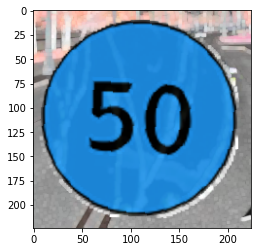

In [13]:
plt.imshow(img)
plt.show()

In [14]:
hog_vec, hog_vis = feature.hog(img, visualize=True)

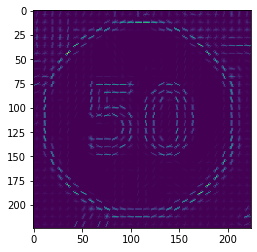

In [15]:
plt.imshow(hog_vis)
plt.show()

In [16]:
hog_vis.ravel()

array([0., 0., 0., ..., 0., 0., 0.])

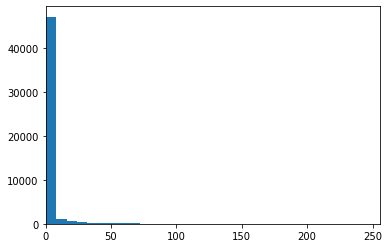

In [17]:
fig, ax = plt.subplots(1, 1)
ax.hist(hog_vis.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256);

In [18]:
# name_folder = {0:'1_предупреждающие', 1:'2_приоритета', 2:'3_запрещающие', 3:'4_предписывающие', 4:'5_особых предписаний', 5:'6_информационные', 6:'7_сервиса', 7:'8_доп информации(таблички)'}

# df_all = pd.DataFrame(columns=[i for i in range(50176)])

# df_0 = pd.DataFrame(columns=[i for i in range(50176)])
# df_1 = pd.DataFrame(columns=[i for i in range(50176)])
# df_2 = pd.DataFrame(columns=[i for i in range(50176)])


# # df_0 = np.zeros((0, 2))
# # df_1 = np.zeros((0, 2))
# # df_2 = np.zeros((0, 2))

# #df_all = np.zeros((0, 2))


# for b in name_folder.keys():

#   path = '/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС'+f'/{name_folder[b]}'
#   #path = '/content'+f'/{name_folder[b]}'

#   photos = os.listdir(path)

#   img_sl = {}

#   for i, photo in enumerate(tqdm(photos)):

#     photo_pth = f'{path}/'+f'{photo}'     

#     img = 255 - cv2.imread(photo_pth, cv2.COLOR_BGR2RGB)

#     hog_vec, hog_vis = feature.hog(img, visualize=True)

#     #df_all = np.append(df_all, [[hog_vis.ravel(),b]], axis = 0)

#     df_all = df_all.append(pd.Series(hog_vis.ravel()), ignore_index=True)
#     df_all.loc[(df_all.shape[0] - 1), 'target'] = b

#     for n in range(3):

#       hog_vec_one, hog_vis_one = feature.hog(img[:,:,n], visualize=True)

#       #data0 = np.reshape(img[:,:,n], 50176)
#       data0 = pd.Series(hog_vis_one.ravel())
#       img_sl[n] = data0


#     # df_0 = np.append(df_0, [[img_sl[0],b]], axis = 0)
#     # df_1 = np.append(df_1, [[img_sl[1],b]], axis = 0)
#     # df_2 = np.append(df_2, [[img_sl[2],b]], axis = 0)

#     df_0 = df_0.append(img_sl[0], ignore_index=True)
#     df_0.loc[(df_0.shape[0] - 1), 'target'] = b

#     df_1 = df_1.append(img_sl[1], ignore_index=True)
#     df_1.loc[(df_1.shape[0] - 1), 'target'] = b

#     df_2 = df_2.append(img_sl[2], ignore_index=True)
#     df_2.loc[(df_2.shape[0] - 1), 'target'] = b

In [19]:
# df_all.to_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_all_2_hog.csv')
# df_0.to_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_2_0_hog.csv')
# df_1.to_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_2_1_hog.csv')
# df_2.to_csv('/content/drive/MyDrive/Colab Notebooks/НИС Данные/НИС/НИС/df_2_2_hog.csv')

## Опыты PCA

In [20]:
# model_pca = PCA()
# df_0_x = df_0.drop('target', axis=1)
# faces_images = df_0_x
# model_pca.fit(faces_images.values)

# plt.figure(figsize=(10,7))
# plt.plot(np.cumsum(model_pca.explained_variance_ratio_), color='k', lw=2)
# plt.xlabel('Number of components')
# plt.ylabel('Total explained variance')
# plt.xlim(0, 100)
# plt.yticks(np.arange(0, 1.1, 0.1))
# plt.axvline(85, c='b')
# plt.axhline(0.9, c='r')
# plt.show();

#### 85 признаков сохраняют 90% инфрмации

## Функция для обучения c PCA

In [21]:
def model_ka_pca(df_0, df_1, df_2, mod_0, mod_1, mod_2, n_pca):
   
    # разбиение индексов
    x_train_ind, x_test_ind = train_test_split(df_0.index, test_size=0.3, random_state=42)
    
    # разбивка данных для обучения моделек
    x_y_train_0 = df_0.loc[x_train_ind]
    x_y_train_1 = df_1.loc[x_train_ind]
    x_y_train_2 = df_2.loc[x_train_ind]

    x_y_test_0 = df_0.loc[x_test_ind]
    x_y_test_1 = df_1.loc[x_test_ind]
    x_y_test_2 = df_2.loc[x_test_ind]


    x_train_0 = x_y_train_0.drop('target', axis=1)
    x_train_1 = x_y_train_1.drop('target', axis=1)
    x_train_2 = x_y_train_2.drop('target', axis=1)

    x_test_0 = x_y_test_0.drop('target', axis=1)
    x_test_1 = x_y_test_1.drop('target', axis=1)
    x_test_2 = x_y_test_2.drop('target', axis=1)

    y_train = x_y_train_0['target']

    y_test = x_y_test_0['target']
    
    
    # применим PCA
    model_pca_0 = PCA(n_pca)
    model_pca_1 = PCA(n_pca)
    model_pca_2 = PCA(n_pca)
    
    x_train_0_pca = model_pca_0.fit_transform(x_train_0)
    x_train_1_pca = model_pca_1.fit_transform(x_train_1)
    x_train_2_pca = model_pca_2.fit_transform(x_train_2)
    
    x_test_0_pca = model_pca_0.transform(x_test_0)
    x_test_1_pca = model_pca_1.transform(x_test_1)
    x_test_2_pca = model_pca_2.transform(x_test_2)
    
    
    
    # обучение моделек, получение предсказаний для каждой
 
    mod_0.fit(x_train_0_pca, y_train)
    mod_1.fit(x_train_1_pca, y_train)
    mod_2.fit(x_train_2_pca, y_train)
    
    pred_0 = mod_0.predict(x_test_0_pca)
    pred_1 = mod_1.predict(x_test_1_pca)
    pred_2 = mod_2.predict(x_test_2_pca)
    
    
    # самое часто встречающееся значение среди всех предсказаний через медиану
    try:
        pred = list(map(np.median, (list(zip(pred_0[:,0],pred_1[:,0],pred_2[:,0])))))
    
    except IndexError:

        pred = list(map(np.median, (list(zip(pred_0,pred_1,pred_2)))))
    
    # считаем accuracy каждой модельки и суммарное
    
    accuracy_0 = accuracy_score(pred_0, y_test)
    accuracy_1 = accuracy_score(pred_1, y_test)
    accuracy_2 = accuracy_score(pred_2, y_test)
    
    accuracy_vseh = accuracy_score(pred, y_test)
    
    itog = {'1_канал': accuracy_0, '2_канал': accuracy_1, '3_канал':accuracy_2, 'суммарное':accuracy_vseh}
    
    return itog

## Функция для обучения c LDA

In [22]:
def model_ka_lda(df_0, df_1, df_2, mod_0, mod_1, mod_2, n_lda):

    # разбиение индексов
    x_train_ind, x_test_ind = train_test_split(df_0.index, test_size=0.3, random_state=42)
    
    # разбивка данных для обучения моделек
    x_y_train_0 = df_0.loc[x_train_ind]
    x_y_train_1 = df_1.loc[x_train_ind]
    x_y_train_2 = df_2.loc[x_train_ind]

    x_y_test_0 = df_0.loc[x_test_ind]
    x_y_test_1 = df_1.loc[x_test_ind]
    x_y_test_2 = df_2.loc[x_test_ind]


    x_train_0 = x_y_train_0.drop('target', axis=1)
    x_train_1 = x_y_train_1.drop('target', axis=1)
    x_train_2 = x_y_train_2.drop('target', axis=1)

    x_test_0 = x_y_test_0.drop('target', axis=1)
    x_test_1 = x_y_test_1.drop('target', axis=1)
    x_test_2 = x_y_test_2.drop('target', axis=1)

    y_train = x_y_train_0['target']

    y_test = x_y_test_0['target']
    
    
    # применим PCA
    model_lda_0 = LDA(n_components = n_lda)
    model_lda_1 = LDA(n_components = n_lda)
    model_lda_2 = LDA(n_components = n_lda)
    
    x_train_0_lda = model_lda_0.fit(x_train_0, y_train).transform(x_train_0)
    x_train_1_lda = model_lda_1.fit(x_train_1, y_train).transform(x_train_1)
    x_train_2_lda = model_lda_2.fit(x_train_2, y_train).transform(x_train_2)
    
    x_test_0_lda = model_lda_0.transform(x_test_0)
    x_test_1_lda = model_lda_1.transform(x_test_1)
    x_test_2_lda = model_lda_2.transform(x_test_2)
    
    
    
    # обучение моделек, получение предсказаний для каждой
 
    mod_0.fit(x_train_0_lda, y_train)
    mod_1.fit(x_train_1_lda, y_train)
    mod_2.fit(x_train_2_lda, y_train)
    
    pred_0 = mod_0.predict(x_test_0_lda)
    pred_1 = mod_1.predict(x_test_1_lda)
    pred_2 = mod_2.predict(x_test_2_lda)
    
    
    # самое часто встречающееся значение среди всех предсказаний через медиану
    try:
        pred = list(map(np.median, (list(zip(pred_0[:,0],pred_1[:,0],pred_2[:,0])))))
    
    except IndexError:

        pred = list(map(np.median, (list(zip(pred_0,pred_1,pred_2)))))
    
    # считаем accuracy каждой модельки и суммарное
    
    accuracy_0 = accuracy_score(pred_0, y_test)
    accuracy_1 = accuracy_score(pred_1, y_test)
    accuracy_2 = accuracy_score(pred_2, y_test)
    
    accuracy_vseh = accuracy_score(pred, y_test)
    
    itog = {'1_канал': accuracy_0, '2_канал': accuracy_1, '3_канал':accuracy_2, 'суммарное':accuracy_vseh}
    
    return itog

## Функция для обучения 

In [23]:
def model_ka(df_0, df_1, df_2, mod_0, mod_1, mod_2):
   
    # разбиение индексов
    x_train_ind, x_test_ind = train_test_split(df_0.index, test_size=0.3, random_state=42)
    
    # разбивка данных для обучения моделек
    x_y_train_0 = df_0.loc[x_train_ind]
    x_y_train_1 = df_1.loc[x_train_ind]
    x_y_train_2 = df_2.loc[x_train_ind]

    x_y_test_0 = df_0.loc[x_test_ind]
    x_y_test_1 = df_1.loc[x_test_ind]
    x_y_test_2 = df_2.loc[x_test_ind]


    x_train_0 = x_y_train_0.drop('target', axis=1)
    x_train_1 = x_y_train_1.drop('target', axis=1)
    x_train_2 = x_y_train_2.drop('target', axis=1)

    x_test_0 = x_y_test_0.drop('target', axis=1)
    x_test_1 = x_y_test_1.drop('target', axis=1)
    x_test_2 = x_y_test_2.drop('target', axis=1)

    y_train = x_y_train_0['target']

    y_test = x_y_test_0['target']
    
    
    # обучение моделек, получение предсказаний для каждой
 
    mod_0.fit(x_train_0, y_train)
    mod_1.fit(x_train_1, y_train)
    mod_2.fit(x_train_2, y_train)
    
    pred_0 = mod_0.predict(x_test_0)
    pred_1 = mod_1.predict(x_test_1)
    pred_2 = mod_2.predict(x_test_2)
    
    
    # самое часто встречающееся значение среди всех предсказаний через медиану
    try:
        pred_median = []
        for i in range(len(pred_0)):
          pred_median.append(np.median([pred_0[i], pred_1[i], pred_2[i]]))
    
    except IndexError:

        pred = list(map(np.median, (list(zip(pred_0,pred_1,pred_2)))))
    
    # считаем accuracy каждой модельки и суммарное
    
    accuracy_0 = accuracy_score(pred_0, y_test)
    accuracy_1 = accuracy_score(pred_1, y_test)
    accuracy_2 = accuracy_score(pred_2, y_test)
    
    accuracy_vseh = accuracy_score(pred_median, y_test)
    
    itog = {'1_канал': accuracy_0, '2_канал': accuracy_1, '3_канал':accuracy_2, 'суммарное':accuracy_vseh}
    
    return itog

## Функция для обучения c HOG

In [32]:
def model_hog(df_0, df_1, df_2, df_all, mod_0, mod_1, mod_2, mod_all):
   
    # разбиение индексов
    x_train_ind, x_test_ind = train_test_split(df_0.index, test_size=0.3, random_state=42)
    
    # разбивка данных для обучения моделек
    x_y_train_0 = df_0.loc[x_train_ind]
    x_y_train_1 = df_1.loc[x_train_ind]
    x_y_train_2 = df_2.loc[x_train_ind]
    x_y_train_all = df_all.loc[x_train_ind]

    x_y_test_0 = df_0.loc[x_test_ind]
    x_y_test_1 = df_1.loc[x_test_ind]
    x_y_test_2 = df_2.loc[x_test_ind]
    x_y_test_all = df_all.loc[x_test_ind]


    x_train_0 = x_y_train_0.drop('target', axis=1)
    x_train_1 = x_y_train_1.drop('target', axis=1)
    x_train_2 = x_y_train_2.drop('target', axis=1)
    x_train_all = x_y_train_all.drop('target', axis=1)

    x_test_0 = x_y_test_0.drop('target', axis=1)
    x_test_1 = x_y_test_1.drop('target', axis=1)
    x_test_2 = x_y_test_2.drop('target', axis=1)
    x_test_all = x_y_test_all.drop('target', axis=1)

    y_train = x_y_train_0['target']

    y_test = x_y_test_0['target']
    
    
    # обучение моделек, получение предсказаний для каждой
 
    mod_0.fit(x_train_0, y_train)
    mod_1.fit(x_train_1, y_train)
    mod_2.fit(x_train_2, y_train)
    mod_all.fit(x_train_all, y_train)
    
    pred_0 = mod_0.predict(x_test_0)
    pred_1 = mod_1.predict(x_test_1)
    pred_2 = mod_2.predict(x_test_2)
    pred_all = mod_all.predict(x_test_all)
    
    
    # самое часто встречающееся значение среди всех предсказаний через медиану
    try:
        pred_median = []
        for i in range(len(pred_0)):
          pred_median.append(np.median([pred_0[i], pred_1[i], pred_2[i]]))

    
    except IndexError:

        pred = list(map(np.median, (list(zip(pred_0,pred_1,pred_2)))))
    
    # считаем accuracy каждой модельки и суммарное
    
    accuracy_0 = accuracy_score(pred_0, y_test)
    accuracy_1 = accuracy_score(pred_1, y_test)
    accuracy_2 = accuracy_score(pred_2, y_test)

    accuracy_vseh = accuracy_score(pred_median, y_test)

    accuracy_3 = accuracy_score(pred_all, y_test)
    
    itog = {'1_канал': accuracy_0, '2_канал': accuracy_1, '3_канал':accuracy_2, 'суммарное':accuracy_vseh, 'общий_канал': accuracy_3}
    
    return itog

In [167]:
np.median([pred_0[1], pred_0[2], pred_0[3]])

4.0

## Обучим модели

In [ ]:
n_pca = 100

n_lda = None

### SGDClassifier

In [ ]:
cl_0 = SGDClassifier()
cl_1 = SGDClassifier()
cl_2 = SGDClassifier()

In [ ]:
model_ka(df_0, df_1, df_2, cl_0, cl_1, cl_2)

{'1_канал': 0.6908212560386473,
 '2_канал': 0.821256038647343,
 '3_канал': 0.7632850241545893,
 'суммарное': 0.8067632850241546}

In [169]:
cl_0 = SGDClassifier(penalty = 'l1')
cl_1 = SGDClassifier(penalty = 'l1')
cl_2 = SGDClassifier(penalty = 'l1')

In [172]:
m_sgd = model_hog(df_0_or, df_1_or, df_2_or, cl_0, cl_1, cl_2)
m_sgd

{'1_канал': 0.7439613526570048,
 '2_канал': 0.8164251207729468,
 '3_канал': 0.7922705314009661,
 'суммарное': 0.8260869565217391}

c PCA

In [ ]:
m_sgd_pca = model_ka_pca(df_0, df_1, df_2, cl_0, cl_1, cl_2, n_pca)
m_sgd_pca

{'1_канал': 0.6183574879227053,
 '2_канал': 0.714975845410628,
 '3_канал': 0.6908212560386473,
 'суммарное': 0.7777777777777778}

c LDA

In [ ]:
m_sgd_lda = model_ka_lda(df_0, df_1, df_2, cl_0, cl_1, cl_2, n_lda)
m_sgd_lda

{'1_канал': 0.4830917874396135,
 '2_канал': 0.6038647342995169,
 '3_канал': 0.5458937198067633,
 'суммарное': 0.6231884057971014}

HOG на каждый канал отдельно и на общий

In [26]:
cl_0 = SGDClassifier(penalty = 'l1')
cl_1 = SGDClassifier(penalty = 'l1')
cl_2 = SGDClassifier(penalty = 'l1')
cl_all = SGDClassifier(penalty = 'l1')

In [37]:
m_sgd = model_hog(df_0, df_1, df_2, df_all, cl_0, cl_1, cl_2, cl_all)
m_sgd

{'1_канал': 0.9033816425120773,
 '2_канал': 0.893719806763285,
 '3_канал': 0.8840579710144928,
 'общий_канал': 0.9082125603864735,
 'суммарное': 0.9033816425120773}

### SVC

In [ ]:
svc_0 = SVC(kernel='rbf')
svc_1 = SVC(kernel='rbf')
svc_2 = SVC(kernel='rbf')

In [ ]:
model_ka(df_0, df_1, df_2, svc_0, svc_1, svc_2)

{'1_канал': 0.6666666666666666,
 '2_канал': 0.7632850241545893,
 '3_канал': 0.748792270531401,
 'суммарное': 0.7584541062801933}

In [35]:
svc_0 = SVC(kernel='linear')
svc_1 = SVC(kernel='linear')
svc_2 = SVC(kernel='linear')
svc_all = SVC(kernel='linear')

In [ ]:
m_svc = model_ka(df_0, df_1, df_2, svc_0, svc_1, svc_2)
m_svc

{'1_канал': 0.7874396135265701,
 '2_канал': 0.8260869565217391,
 '3_канал': 0.7971014492753623,
 'суммарное': 0.8405797101449275}

с PCA

In [ ]:
m_svc_pca = model_ka_pca(df_0, df_1, df_2, svc_0, svc_1, svc_2, n_pca)
m_svc_pca

{'1_канал': 0.714975845410628,
 '2_канал': 0.8067632850241546,
 '3_канал': 0.7681159420289855,
 'суммарное': 0.7922705314009661}

HOG на каждый канал отдельно и на общий

In [36]:
m_hog = model_hog(df_0, df_1, df_2, df_all, svc_0, svc_1, svc_2, svc_all)
m_hog

{'1_канал': 0.8840579710144928,
 '2_канал': 0.8840579710144928,
 '3_канал': 0.8792270531400966,
 'общий_канал': 0.8985507246376812,
 'суммарное': 0.8888888888888888}

### KNeighborsClassifier

In [38]:
cn_0 = KNeighborsClassifier(n_jobs = -1)
cn_1 = KNeighborsClassifier(n_jobs = -1)
cn_2 = KNeighborsClassifier(n_jobs = -1)

In [ ]:
model_ka(df_0, df_1, df_2, cn_0, cn_1, cn_2)

{'1_канал': 0.6183574879227053,
 '2_канал': 0.6956521739130435,
 '3_канал': 0.714975845410628,
 'суммарное': 0.6859903381642513}

In [ ]:
cn_0 = KNeighborsClassifier(n_jobs = -1, weights='distance')
cn_1 = KNeighborsClassifier(n_jobs = -1, weights='distance')
cn_2 = KNeighborsClassifier(n_jobs = -1, weights='distance')

In [ ]:
model_ka(df_0, df_1, df_2, cn_0, cn_1, cn_2)

{'1_канал': 0.6231884057971014,
 '2_канал': 0.7101449275362319,
 '3_канал': 0.748792270531401,
 'суммарное': 0.6956521739130435}

In [39]:
cn_0 = KNeighborsClassifier(n_jobs = -1, weights='distance', n_neighbors = 2)
cn_1 = KNeighborsClassifier(n_jobs = -1, weights='distance', n_neighbors = 2)
cn_2 = KNeighborsClassifier(n_jobs = -1, weights='distance', n_neighbors = 2)
cn_all = KNeighborsClassifier(n_jobs = -1, weights='distance', n_neighbors = 2)

In [41]:
m_kn = model_hog(df_0, df_1, df_2, df_all, cn_0, cn_1, cn_2, cn_all)
m_kn

{'1_канал': 0.7729468599033816,
 '2_канал': 0.8405797101449275,
 '3_канал': 0.8357487922705314,
 'общий_канал': 0.8357487922705314,
 'суммарное': 0.8309178743961353}

c PCA

In [ ]:
m_kn_pca = model_ka_pca(df_0, df_1, df_2, cn_0, cn_1, cn_2, n_pca)
m_kn_pca

{'1_канал': 0.7342995169082126,
 '2_канал': 0.8164251207729468,
 '3_канал': 0.855072463768116,
 'суммарное': 0.8309178743961353}

HOG на каждый канал отдельно и на общий

In [42]:
m_kn = model_hog(df_0, df_1, df_2, df_all, cn_0, cn_1, cn_2, cn_all)
m_kn

{'1_канал': 0.7729468599033816,
 '2_канал': 0.8405797101449275,
 '3_канал': 0.8357487922705314,
 'общий_канал': 0.8357487922705314,
 'суммарное': 0.8309178743961353}

### RandomForestClassifier

In [44]:
rf_0 = RandomForestClassifier()
rf_1 = RandomForestClassifier()
rf_2 = RandomForestClassifier()
rf_all = RandomForestClassifier()

In [ ]:
m_rf = model_ka(df_0, df_1, df_2, rf_0, rf_1, rf_2)
m_rf

{'1_канал': 0.7777777777777778,
 '2_канал': 0.7874396135265701,
 '3_канал': 0.7729468599033816,
 'суммарное': 0.8067632850241546}

c PCA

In [ ]:
m_rf_pca = model_ka_pca(df_0, df_1, df_2, rf_0, rf_1, rf_2, n_pca)
m_rf_pca

{'1_канал': 0.7681159420289855,
 '2_канал': 0.7777777777777778,
 '3_канал': 0.8260869565217391,
 'суммарное': 0.8019323671497585}

HOG на каждый канал отдельно и на общий

In [45]:
m_rf = model_hog(df_0, df_1, df_2, df_all, rf_0, rf_1, rf_2, rf_all)
m_rf

{'1_канал': 0.8164251207729468,
 '2_канал': 0.8019323671497585,
 '3_канал': 0.8164251207729468,
 'общий_канал': 0.782608695652174,
 'суммарное': 0.8164251207729468}

### CatBoost

In [ ]:
clf_0 = CatBoostClassifier(loss_function='MultiClass',depth = 3,\
                                                iterations = 180,\
                                                l2_leaf_reg = 1,\
                                                learning_rate = 0.25075,
                                                verbose=False)

In [ ]:
clf_1 = CatBoostClassifier(loss_function='MultiClass',depth = 3,\
                                                iterations = 180,\
                                                l2_leaf_reg = 1,\
                                                learning_rate = 0.25075,
                                                verbose=False)

In [ ]:
clf_2 = CatBoostClassifier(loss_function='MultiClass',depth = 3,\
                                                iterations = 180,\
                                                l2_leaf_reg = 1,\
                                                learning_rate = 0.25075,
                                                verbose=False)

In [ ]:
# m_cb = model_ka(df_0, df_1, df_2, clf_0, clf_1, clf_2)
# m_cb

In [ ]:
m_cb = {'1_канал': 0.7246376811594203,
 '2_канал': 0.7632850241545893,
 '3_канал': 0.7971014492753623,
 'суммарное': 0.7681159420289855}

c PCA

In [ ]:
m_cb_pca = model_ka_pca(df_0, df_1, df_2, clf_0, clf_1, clf_2, n_pca)
m_cb_pca

{'1_канал': 0.7536231884057971,
 '2_канал': 0.7922705314009661,
 '3_канал': 0.7922705314009661,
 'суммарное': 0.8019323671497585}

## Графики и вывод

In [47]:
list(m_sgd.keys())

['1_канал', '2_канал', '3_канал', 'суммарное', 'общий_канал']

In [48]:
no_pca = {'SGDClassifier':m_sgd['суммарное'], 
          'SVC':m_svc['суммарное'],
          'KNeighbors':m_kn['суммарное'],
          'RandomForest':m_rf['суммарное'],
          'CatBoost':m_cb['суммарное']}


with_pca = {'SGDClassifier':m_sgd_pca['суммарное'], 
          'SVC':m_svc_pca['суммарное'],
          'KNeighbors':m_kn_pca['суммарное'],
          'RandomForest':m_rf_pca['суммарное'],
          'CatBoost':m_cb_pca['суммарное']}

NameError: ignored

In [49]:
fig = go.Figure(data=[
    go.Bar(name='SGDClassifier', x=list(m_sgd.keys()), y=list(m_sgd.values())),
    go.Bar(name='SVC', x=list(m_svc.keys()), y=list(m_svc.values())),
    go.Bar(name='KNeighbors', x=list(m_kn.keys()), y=list(m_kn.values())),
    go.Bar(name='RandomForest', x=list(m_rf.keys()), y=list(m_rf.values())),
    go.Bar(name='CatBoost', x=list(m_cb.keys()), y=list(m_cb.values())),
])


fig.update_yaxes(title_text="Accuracy", range = (0.6,0.85))
fig.update_xaxes(title_text="Канал (цвет)")
fig.update_layout(title = 'Accuracy моделек обученных на разных каналах + ансамбль')
fig.show()


fig2 = go.Figure(data=[
    go.Bar(name='NO_PCA', x=list(no_pca.keys()), y=list(no_pca.values())),
    go.Bar(name='WITH_PCA', x=list(with_pca.keys()), y=list(with_pca.values())),
])


fig2.update_yaxes(title_text="Accuracy", range = (0.6,0.85))
fig2.update_xaxes(title_text="PCA")
fig2.update_layout(title = 'Accuracy моделек c использованием и без PCA')
fig2.show()

NameError: ignored

- хуже всех модельки обучаются на 1 канале (красный цвет)
- лучше всех на голубом
- на SVC и RandomForest суммарная модель показывает лучшие результаты чем на отдельных каналах (проверить на стабильность)
- лучший результат у SVC (0.84)
- при снижении размерности в 500 раз качество у KNeighbors и CatBoost выросло
- обучение моделей с использованием PCA происходит быстрее, особенно в случае CatBoost